# Guiding questions

How does graduate student gender diversity at Columbia compare to its peer institutions?

In [168]:
from collections import defaultdict
import math
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [169]:
TOTALS = pickle.load(open('../../../data/SE-Detailed_Sex.p', 'rb'))
S_TOTALS = pickle.load(open('../../../data/S_Sex_Graduates.p', 'rb'))

years = sorted(TOTALS.keys())
institutions = sorted(TOTALS[ max(years) ].keys())
fields = {
    'Science': set(),
    'Engineering': set()
}
for year in years:
    inst_stats = TOTALS[year]['Columbia University in the City of New York']
    for seh in inst_stats.keys():
        for field in inst_stats[seh].keys():
            fields[seh].add(field)
fields['Science'] = sorted(fields['Science'])
fields['Engineering'] = sorted(fields['Engineering'])

print(f'Data set describes years {min(years)} - {max(years)} for {len(institutions)} institutions and {len(fields["Science"]) + len(fields["Engineering"])} fields.')

Data set describes years 1994 - 2016 for 11 institutions and 39 fields.


In [170]:
# Convenient function for making subplots for every institution
def subplots(num=len(institutions), cols=2, figsize=8):
    rows = math.ceil(num / cols)
    return plt.subplots(rows, cols, figsize=(figsize * cols, figsize * rows))

# Returns female proportions for an institution in a field
def get_proportions(seh, field, inst='Columbia University in the City of New York'):
    proportions = []
    for year in years:
        field_stats = TOTALS[year][inst][seh].get(field, None)
        if field_stats is None:
            proportions.append(None)
        else:
            proportions.append(field_stats.get('Female', 0) / field_stats['Total for selected values'])
    return proportions

# Plots female proportions for every institution for a field, highlighting one, in a line graph
def plot_inst(ax, seh, field, highlight='Columbia University in the City of New York'):
    for inst in institutions:
        if inst != highlight:
            ax.plot(years, get_proportions(seh, field, inst), label=inst)
    ax.plot(years, get_proportions(seh, field, highlight), label=highlight, linewidth=3, color='black')
    
    ax.set_ylabel('Percent female')
    ax.legend()
    ax.set_ylim(top=1, bottom=0)
    ax.set_title(f'{field}: Comparing Columbia\'s peers')
    
    # Format y tick labels to be percentages
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

# Returns female and male headcounts for a field in an institution
def get_counts(seh, field, inst='Columbia University in the City of New York', default=None):
    females = []
    males = []
    for year in years:
        stats = TOTALS[year][inst][seh].get(field, None)
        if stats is None:
            females.append(default)
            males.append(default)
            continue
        females.append(stats.get('Female', 0))
        males.append(stats.get('Male', 0))
    return females, males

# Plots a female and male headcounts line graph for a field in an institution
def plot_counts(ax, seh, field, inst='Columbia University in the City of New York'):
    females, males = get_counts(seh, field, inst)
    ax.plot(years, females, label='Female')
    ax.plot(years, males, label='Male')
    ax.legend()
    ax.set_ylim(bottom=0)
    ax.set_title(f'{field}: Columbia\'s headcounts by sex')
    ax.set_ylabel('Number of people')

def plot_connected(ax, seh, field, inst='Columbia University in the City of New York'):
    f, m = get_counts(seh, field, inst, default=0)
    ax.plot(f, m, color='lightgray')
    ax.scatter(f, m, c=[i for i in range(len(m))], cmap='viridis')

    for i in [0, -1]:
        ax.annotate(years[i], (f[i], m[i]))
    anh
    _, ymax = ax.get_ylim()
    _, xmax = ax.get_xlim()
    top = max(ymax, xmax)
    
    ax.set_ylim(bottom=0, top=top)
    ax.set_xlim(left=0, right=top)
    
    ax.plot([0, top], [0, top], color='gray', linestyle='--')

    ax.set_xlabel('Number of women')
    ax.set_ylabel('Number of men')

## Focusing on complete fields

We have to keep the analysis to fields that have data for every year since 1994. For science, there are 15 out of 30 such fields for Columbia, and 3 for all schools together. Is it possible to analyze an average from only 15?

In [171]:
complete_fields = {
    'Science': [],
    'Engineering': [],
}

for topic in complete_fields.keys():
    for field in fields[topic]:
        f, m = get_counts(topic, field)
        if None not in f and None not in m:
            complete_fields[topic].append(field)

In [215]:
def plot_topic(topic):
    fig, axArr = subplots(len(complete_fields[topic])*3, cols=3)
    for i, field in enumerate(complete_fields[topic]):
        plot_inst(axArr[i, 0], topic, field)
        plot_counts(axArr[i, 1], topic, field)
        plot_connected(axArr[i, 2], topic, field)

In [230]:
def get_overall_counts(topic, inst='Columbia University in the City of New York'):
    overallF = [0 for _ in range(len(years))]
    overallM = [0 for _ in range(len(years))]
    counts = {field: get_counts(topic, field, inst, default=0) for field in complete_fields[topic]}

    for field in complete_fields[topic]:
        f, m = counts[field]
        for i in range(len(years)):
            overallF[i] += f[i]
            overallM[i] += m[i]
    return overallF, overallM

def get_overall_proportions(topic, inst='Columbia University in the City of New York'):
    overallF, overallM = get_overall_counts(topic, inst)
    return [0 if m+f == 0 else f/(m+f) for f, m in zip(overallF, overallM)]

def plot_topic_peers(ax, topic, highlight='Columbia University in the City of New York'):
    for inst in institutions:
        if inst != highlight:
            ax.plot(years, get_overall_proportions(topic, inst), label=inst)
    ax.plot(years, get_overall_proportions(topic, highlight), label=highlight, color='black', linewidth=3)
    ax.set_ylim(bottom=0, top=1)
    ax.set_title(topic)
    ax.legend()

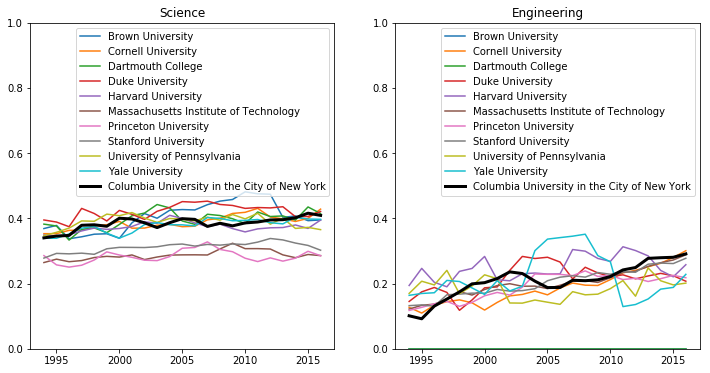

In [211]:
_, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_topic_peers(ax[0], 'Science')
plot_topic_peers(ax[1], 'Engineering')

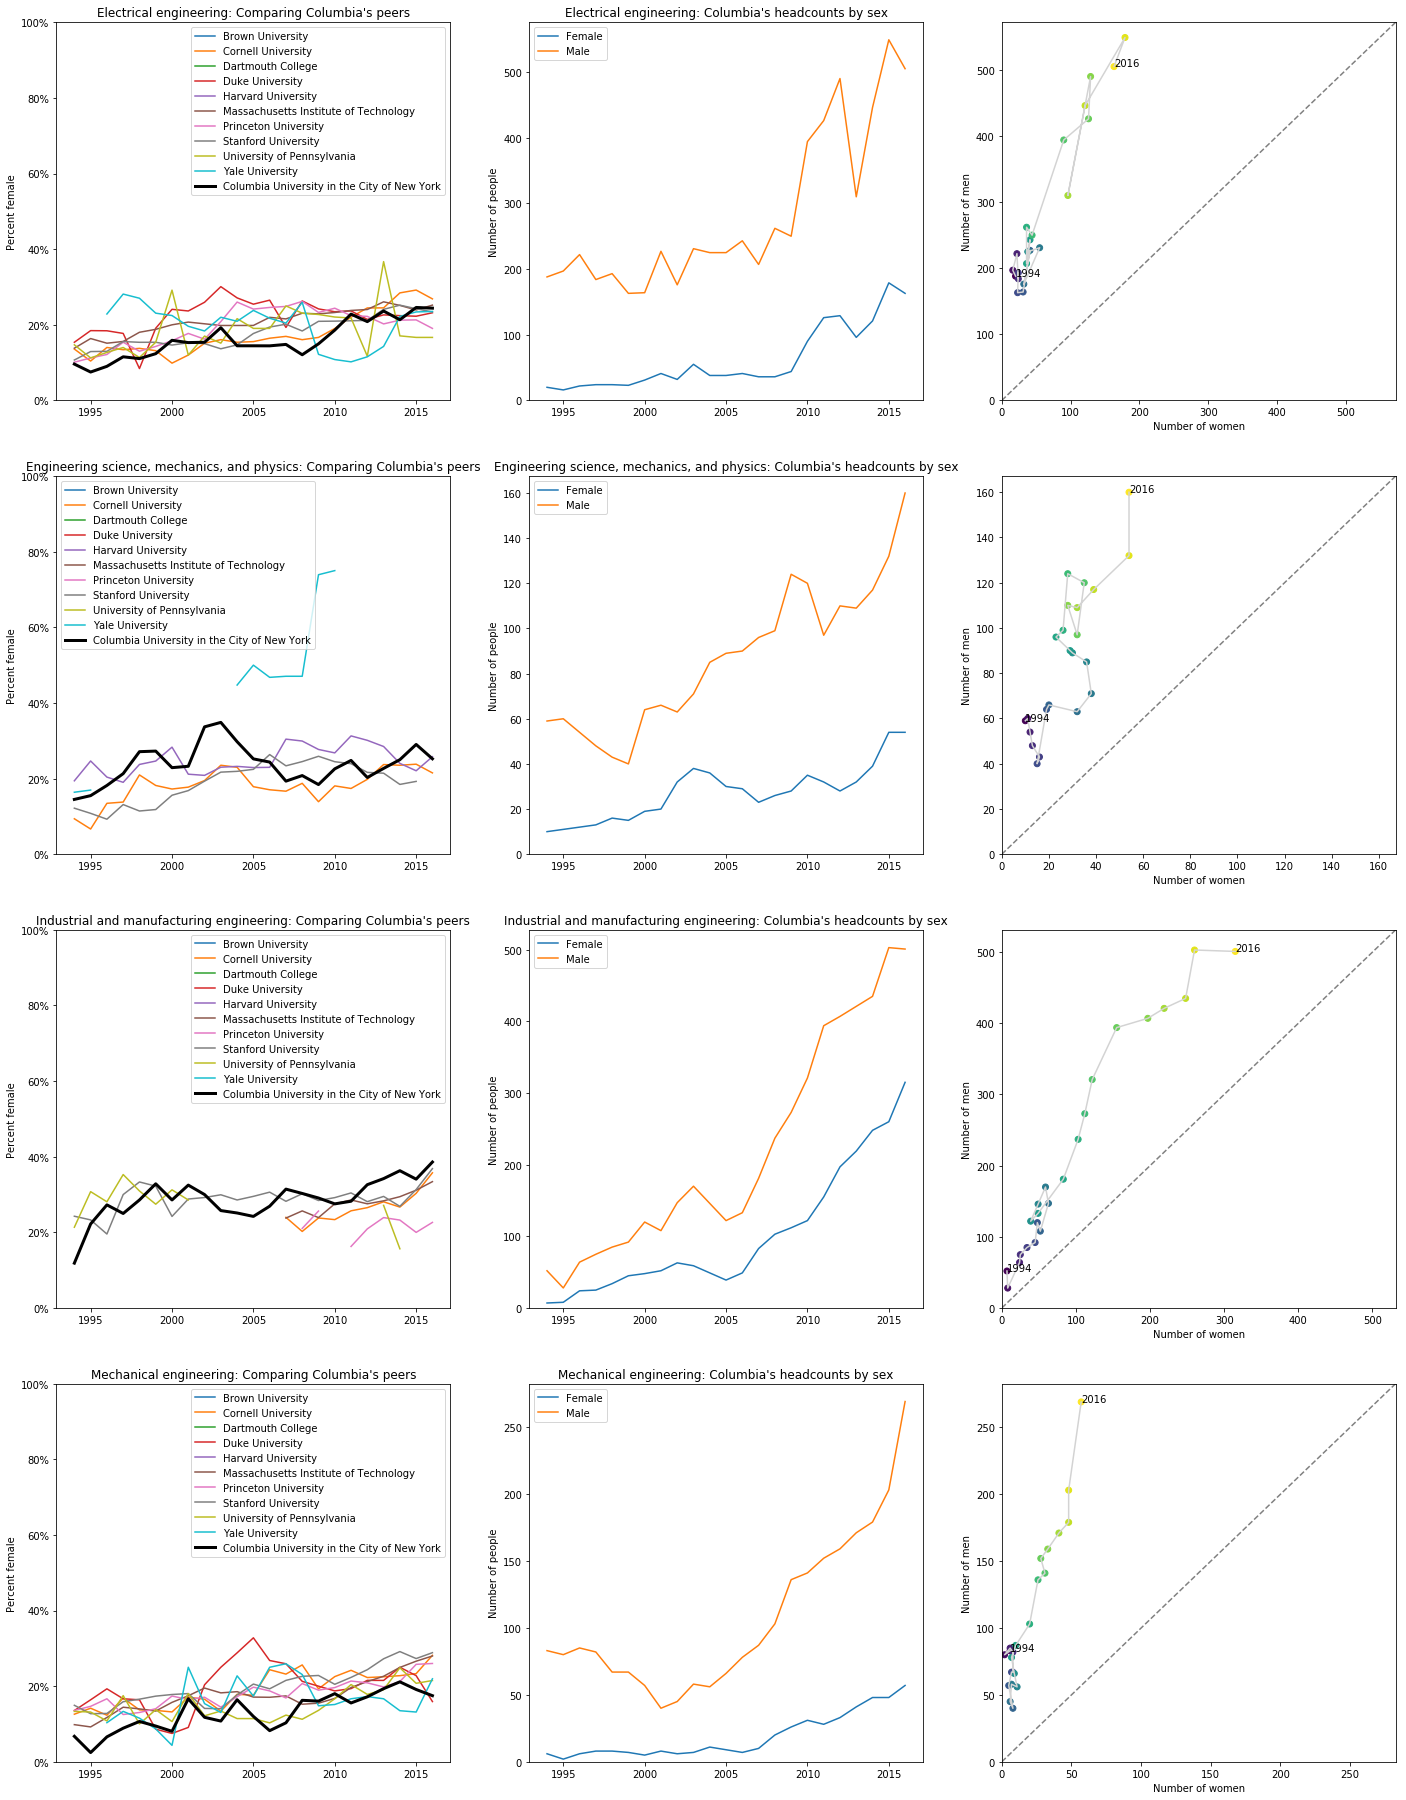

In [235]:
plot_topic('Engineering')

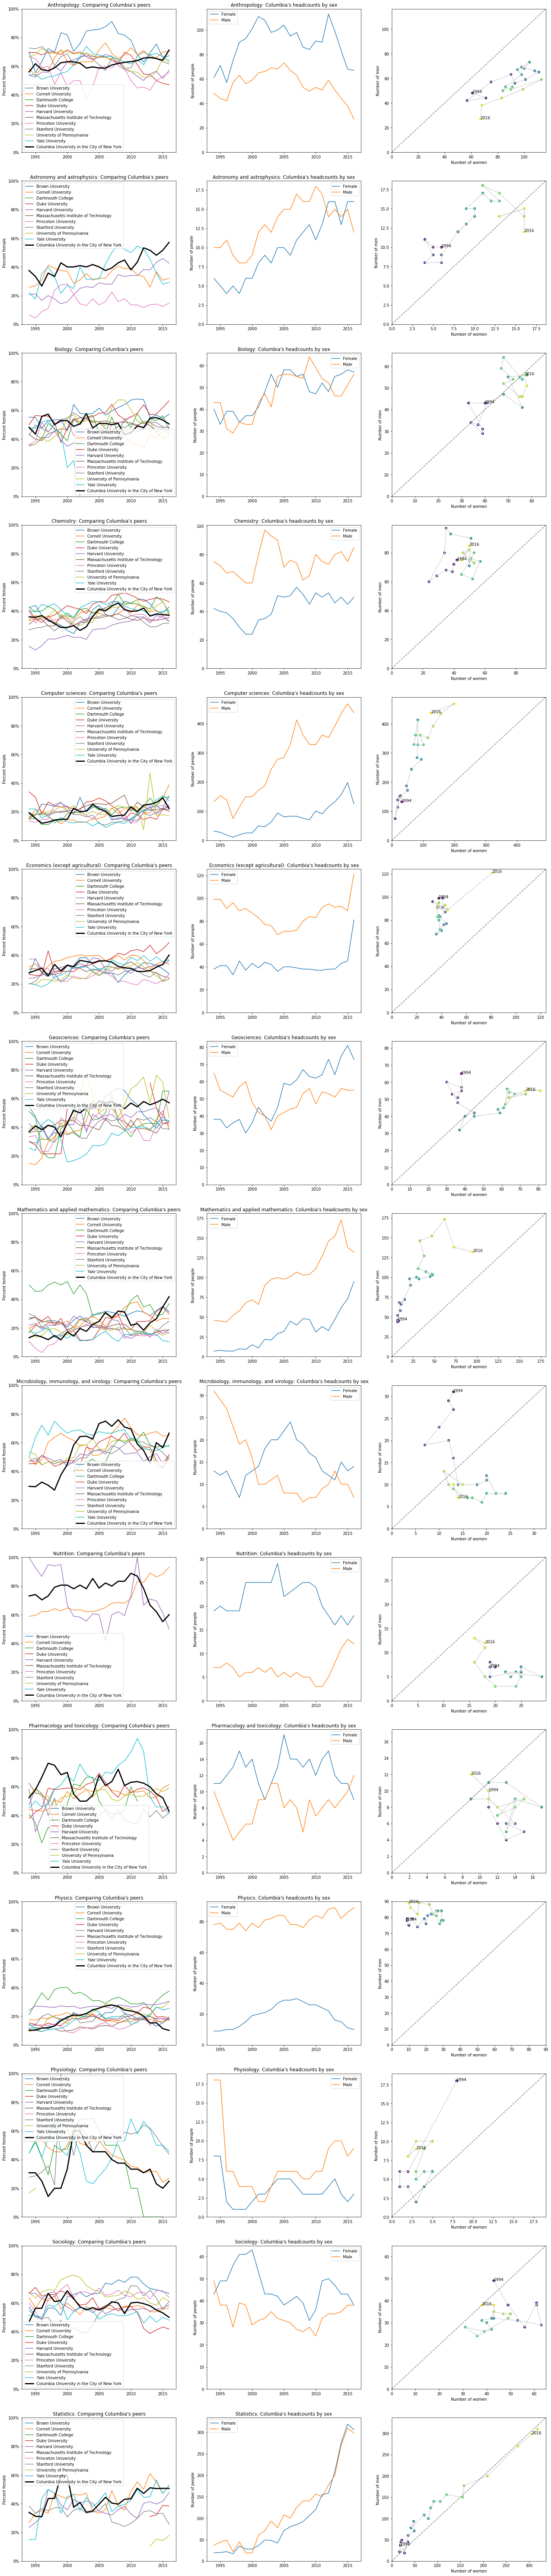

In [216]:
plot_topic('Science')

In [217]:
# Engineering has an interesting drop near 2002. Export all net changes to Flourish
target_years = years[1995 - years[0]:]

df = {}
df['Years'] = target_years
topic = 'Science'

for field in complete_fields[topic]:
    females, males = get_counts(topic, field)
    changes = []
    for year in target_years:
        i = year - years[0]
        changes.append((males[i] - males[i-1]) - (females[i] - females[i-1]))
    df[field] = changes

females, males = get_overall_counts(topic)
changes = []
for year in target_years:
    i = year - years[0]
    changes.append((males[i] - males[i-1]) - (females[i] - females[i-1]))
df[topic] = changes

df = pd.DataFrame(df)
df.to_csv('changes.csv')

In [229]:
topic = 'Science'
df = {
    'Years': years
}
for field in complete_fields[topic]:
    df[field] = get_proportions('Science', field) 
df[topic] = get_overall_proportions(topic)
df = pd.DataFrame(data=df)
df.to_csv('proportions.csv')

In [227]:
df

,Years,Anthropology,Astronomy and astrophysics,Biology,Chemistry,Computer sciences,Economics (except agricultural),Geosciences,Mathematics and applied mathematics,"Microbiology, immunology, and virology",Nutrition,Pharmacology and toxicology,Physics,Physiology,Sociology,Statistics
0,1994,0.559633,0.375000,0.481928,0.358974,0.193939,0.277372,0.368932,0.132075,0.295455,0.730769,0.523810,0.103448,0.307692,0.467391,0.339286
1,1995,0.617391,0.333333,0.434211,0.357143,0.154696,0.292857,0.408602,0.150943,0.292683,0.740741,0.578947,0.102273,0.307692,0.563218,0.312500
2,1996,0.575758,0.266667,0.557143,0.367925,0.120253,0.310606,0.383721,0.137255,0.325000,0.703704,0.666667,0.117647,0.250000,0.563218,0.309859
3,1997,0.568182,0.357143,0.573529,0.339806,0.127907,0.255814,0.413793,0.118644,0.303030,0.730769,0.764706,0.117647,0.142857,0.666667,0.435897
4,1998,0.588235,0.333333,0.500000,0.311828,0.142857,0.335821,0.400000,0.147059,0.269231,0.791667,0.750000,0.131868,0.200000,0.610000,0.437500
5,1999,0.624161,0.428571,0.528571,0.285714,0.147727,0.289062,0.333333,0.116883,0.375000,0.806452,0.684211,0.168539,0.200000,0.616162,0.595745
6,2000,0.631250,0.400000,0.528571,0.285714,0.147727,0.330769,0.428571,0.172414,0.448276,0.806452,0.700000,0.193878,0.333333,0.684783,0.595745
7,2001,0.630682,0.400000,0.488095,0.298246,0.225225,0.319672,0.517241,0.142857,0.583333,0.781250,0.550000,0.208333,0.600000,0.630952,0.375000
8,2002,0.620690,0.409091,0.505263,0.265152,0.200855,0.363636,0.500000,0.196429,0.642857,0.806452,0.500000,0.205882,0.600000,0.573333,0.408333
9,2003,0.586826,0.400000,0.577320,0.290076,0.205212,0.355932,0.536232,0.176471,0.645161,0.781250,0.500000,0.219048,0.500000,0.551282,0.340426
